In [38]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt 
import more_itertools
import random
from torchmetrics import Accuracy
from sklearn.metrics.pairwise import cosine_similarity

# Tokenisation-related libraries
import re
from typing import Union, List
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Setup device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

# Setup random seed
RANDOM_SEED = 42

In [39]:
# Download all necessary NLTK data
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [40]:
# Read the text8 file
with open('../scripts/text8', 'r', encoding='utf-8') as file:
    text8_data = file.read()

# Print first few characters to verify
print("First 100 characters:")
print(text8_data[:1000])

# Print total length
print(f"\nTotal characters: {len(text8_data)}")

# Get initial word count (simple split)
initial_words = text8_data.split()
characters = len(text8_data) / 100
print(f"\nTotal words (raw split): {len(initial_words)}")
print(f"Initial vocabulary size: {len(set(initial_words))}")

First 100 characters:
 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in place of what are regarded as authoritarian political structures and coerc

In [41]:
df = pd.read_csv('../HN Score, Title 10k.csv')
df.title = df.title.str.lower()
df.dropna(inplace= True) # Remove rows with incomplete data

# Convert titles to a single string
titles_text = ' '.join(df.title.astype(str).tolist())

df.head()

,score,title
0,8.0,nasa's 3d-printed rotating detonation rocket e...
1,62.0,heat pumps of the 1800s are becoming the techn...
2,1.0,why you should develop local-first web apps
3,1.0,tool to make twitter archive publishable
4,2.0,fedora packages versus upstream flatpaks


In [42]:
# words = []
# num_lines = 10000
# lines = df.title.tolist()[:num_lines]

# for i in df.title[:num_lines]:
#     for j in str(i).split():
#         if j not in words and j != "nan":
#             words.append(j)



In [43]:
# itos = {num:word for num, word in zip(range(len(words)),words)}
# stoi = {word:num for num,word in itos.items()}

In [44]:
def preprocess_text(text_input: Union[str, List[str]], min_freq: int = 5) -> tuple[List[str], dict]:
    """
    Preprocess text input and create vocabulary.
    """

    # Initialise Lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Define special tokens using a marker that word_tokenize won't split
    SPECIAL_TOKENS = {
        '.': 'XPERIODX',
        ',': 'XCOMMAX',
        '"': 'XQUOTATION_MARKX',
        ';': 'XSEMICOLONX',
        '!': 'XEXCLAMATION_MARKX',
        '?': 'XQUESTION_MARKX',
        '(': 'XLEFT_PARENX',
        ')': 'XRIGHT_PARENX',
        '--': 'XHYPHENSX',
        ':': 'XCOLONX',
        "'": 'XAPOSTROPHEX'
    }
    
    # Mapping for restoring angle brackets
    RESTORE_TOKENS = {
        f'XPERIODX': '<PERIOD>',
        f'XCOMMAX': '<COMMA>',
        f'XQUOTATION_MARKX': '<QUOTATION_MARK>',
        f'XSEMICOLONX': '<SEMICOLON>',
        f'XEXCLAMATION_MARKX': '<EXCLAMATION_MARK>',
        f'XQUESTION_MARKX': '<QUESTION_MARK>',
        f'XLEFT_PARENX': '<LEFT_PAREN>',
        f'XRIGHT_PARENX': '<RIGHT_PAREN>',
        f'XHYPHENSX': '<HYPHENS>',
        f'XCOLONX': '<COLON>',
        f'XAPOSTROPHEX': '<APOSTROPHE>'
    }
    
    def clean_text(text: str) -> str:
        # Convert to lowercase
        text = text.lower()
        
        # Replace special characters with temporary tokens
        for char, token in SPECIAL_TOKENS.items():
            text = text.replace(char, f' {token} ')
        
        # Remove special characters and extra whitespace
        text = re.sub(r'[^a-zA-Z0-9\s_X]', '', text)
        text = re.sub(r'\s+', ' ', text)
        
        return text.strip()

    # Convert input to list of sentences
    if isinstance(text_input, str):
        sentences = sent_tokenize(text_input)
    elif isinstance(text_input, list):
        sentences = []
        for line in text_input:
            if isinstance(line, str):
                try:
                    sentences.extend(sent_tokenize(line))
                except:
                    sentences.append(line)
    else:
        raise ValueError("Input must be either a string or list of strings")

    # Process all sentences
    processed_words = []
    for sentence in sentences:
        # Clean the text
        cleaned_text = clean_text(sentence)
        # Tokenize
        try:
            words = word_tokenize(cleaned_text)
            # Restore angle bracket format
            words = [RESTORE_TOKENS.get(word, word) for word in words]
            # Apply lemmatization only to non-special tokens
            words = [word if word in RESTORE_TOKENS.values() 
                    else lemmatizer.lemmatize(word) 
                    for word in words]
        except:
            words = cleaned_text.split()
        processed_words.extend(words)

    # Count word frequencies
    word_counts = Counter(processed_words)
    
    # Create vocabulary (only including words that meet minimum frequency)
    vocab = [word for word, count in word_counts.items() if count >= min_freq]
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    
    # Filter words based on vocabulary
    processed_words = [word for word in processed_words if word in word_to_idx]
    
    return processed_words, word_to_idx

In [45]:
# # Process text inputs, receive tokens and word to index dictionary
# processed_words, word_to_idx = preprocess_text(text8_data, min_freq=5)

# # Set vocab_size, determine dimensions of layers in model
# vocab_size = len(word_to_idx)

# len(processed_words)
# len(word_to_idx)

In [46]:
# Update 1

def create_skipgram_pairs(processed_words: List[str], 
                         word_to_idx: dict, 
                         context_len: int = 3) -> tuple[List[int], List[List[int]]]:
    """
    Create skipgram pairs from a list of processed words.
    """
    if context_len % 2 == 0:
        raise ValueError("context_len should be an odd number")
        
    window_radius = context_len // 2
    input_indices = []
    context_indices = []
    vocab_size = len(word_to_idx)  # Added this line
    
    # Use sliding window to create pairs
    windows = list(more_itertools.windowed(processed_words, context_len))
    
    for window in windows:
        if None in window:  # Skip incomplete windows
            continue
            
        # Get center word and context
        center_word = window[window_radius]
        context = list(window[:window_radius]) + list(window[window_radius + 1:])
        
        # Only add if all words are in vocabulary AND indices are within range
        if center_word in word_to_idx and all(w in word_to_idx for w in context):
            center_idx = word_to_idx[center_word]
            context_idxs = [word_to_idx[w] for w in context]
            
            # Added this check
            if center_idx < vocab_size and all(idx < vocab_size for idx in context_idxs):
                input_indices.append(center_idx)
                context_indices.append(context_idxs)
    
    return input_indices, context_indices

In [47]:
# def create_skipgram_pairs(processed_words: List[str], 
#                          word_to_idx: dict, 
#                          context_len: int = 3) -> tuple[List[int], List[List[int]]]:
#     """
#     Create skipgram pairs from a list of processed words.
#     """
#     if context_len % 2 == 0:
#         raise ValueError("context_len should be an odd number")
        
#     window_radius = context_len // 2
#     input_indices = []
#     context_indices = []
    
#     # Use sliding window to create pairs
#     windows = list(more_itertools.windowed(processed_words, context_len))
    
#     for window in windows:
#         if None in window:  # Skip incomplete windows
#             continue
            
#         # Get center word and context
#         center_word = window[window_radius]
#         context = list(window[:window_radius]) + list(window[window_radius + 1:])
        
#         # Only add if all words are in vocabulary
#         if center_word in word_to_idx and all(w in word_to_idx for w in context):
#             input_indices.append(word_to_idx[center_word])
#             context_indices.append([word_to_idx[w] for w in context])
    
#     return input_indices, context_indices

In [48]:
# Concatenate the Wikipedia & Hacker News datasets
combined_text = text8_data + " " + titles_text

# Determine input size
input=text8_data[:int(len(combined_text)/100)]

# Process text inputs, receive tokens and word to index dictionary
processed_words, word_to_idx = preprocess_text(input, min_freq=5)

# Set vocab_size, determine dimensions of layers in model
vocab_size = len(word_to_idx)

# Set context length
context_len = 3

# Create Skip-gram dataset using processed, tokenized text input:
input_indices, context_indices = create_skipgram_pairs(processed_words, word_to_idx, context_len)

# Convert dataset indices to tensors
X = torch.tensor(input_indices, dtype=torch.long)
Y = torch.tensor(context_indices, dtype=torch.long)

# Debug prints
print("Vocabulary size:", len(word_to_idx))
print("Original text vocabulary size:", len(combined_text.split()))
print("Dataset size:", len(input_indices))
print("Sample from vocabulary:", list(word_to_idx.keys())[:10])
print("Sample from processed words:", processed_words[:10])
print("X shape: ", X.shape, "; Y shape: ", Y.shape, "; Shapes compatible: ", X.shape[0] == Y.shape[0])

Vocabulary size: 3727
Original text vocabulary size: 17069112
Dataset size: 149736
Sample from vocabulary: ['anarchism', 'originated', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early']
Sample from processed words: ['anarchism', 'originated', 'a', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
X shape:  torch.Size([149736]) ; Y shape:  torch.Size([149736, 2]) ; Shapes compatible:  True


In [49]:
print("Sample from vocabulary:", list(word_to_idx)[:10])

Sample from vocabulary: ['anarchism', 'originated', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early']


In [50]:
# Samples of tensors
X[:10], Y[:10]

(tensor([1, 2, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([[ 0,  2],
         [ 1,  2],
         [ 2,  3],
         [ 2,  4],
         [ 3,  5],
         [ 4,  6],
         [ 5,  7],
         [ 6,  8],
         [ 7,  9],
         [ 8, 10]]))

In [51]:
inputs_len = len(X)
print("Dataset size:", inputs_len, "; context length:", context_len, "; vocab size:", vocab_size)

Dataset size: 149736 ; context length: 3 ; vocab size: 3727


In [52]:
# Set embedding dimensions
emb_dims = 20

# Build Word2Vec model
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, emb_dims):
        super().__init__()
        self.vocab_size = vocab_size
        self.embeddings = nn.Embedding(num_embeddings= vocab_size, embedding_dim= emb_dims)
        self.output_weights = nn.Linear(in_features = emb_dims, out_features = vocab_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, positive_samples, negative_samples):
        # Add dimension checks
        if x.max() >= self.vocab_size or positive_samples.max() >= self.vocab_size or negative_samples.max() >= self.vocab_size:
            raise ValueError(f"Input indices must be less than vocab_size ({self.vocab_size})")

        emb = self.embeddings(x)
        context_weights = self.output_weights.weight[positive_samples]
        negative_sample_weights = self.output_weights.weight[negative_samples]
        positive_out = torch.bmm(context_weights, emb.unsqueeze(-1)).squeeze(-1)
        negative_out = torch.bmm(negative_sample_weights, emb.unsqueeze(-1)).squeeze(-1)
        positive_out = self.sigmoid(positive_out)
        negative_out = self.sigmoid(negative_out)
        positive_loss = -positive_out.log().mean()
        negative_loss = -(1 - negative_out + 10**(-3)).log().mean()
        return positive_loss + negative_loss

# Instantiate model
word2vec = Word2Vec(vocab_size = vocab_size, emb_dims= emb_dims)


In [53]:
# Setup loss function
# loss_fn = nn.BCEWithLogitsLoss()

# Set up optimizer to optimize model's parameters
optimiser = torch.optim.SGD(params= word2vec.parameters(), lr = 0.1)

In [54]:
def evaluate_accuracy(model, X, Y, vocab_size):
    """
    Calculate accuracy by comparing positive sample scores with negative sample scores.
    We want positive context words to have higher scores than random negative words.
    """
    model.eval()
    
    with torch.no_grad():
        # Get embeddings for all input words
        emb = model.embeddings(X)  # [num_samples, embedding_dim]
        
        # Get positive context embeddings
        pos_ctx = model.output_weights.weight[Y]  # [num_samples, 2, embedding_dim]
        
        # Generate negative samples
        neg_samples = torch.randint(0, vocab_size, Y.shape)
        neg_ctx = model.output_weights.weight[neg_samples]
        
        # Calculate similarity scores
        emb_reshaped = emb.unsqueeze(-1)  # [num_samples, embedding_dim, 1]
        pos_scores = torch.bmm(pos_ctx, emb_reshaped).squeeze(-1)  # [num_samples, 2]
        neg_scores = torch.bmm(neg_ctx, emb_reshaped).squeeze(-1)  # [num_samples, 2]
        
        # Accuracy: how often positive scores > negative scores
        accuracy = (pos_scores > neg_scores).float().mean().item()
        
    return accuracy

In [55]:
# Check where input len is used, delete if otherwise

In [56]:
# After creating the dataset
print("Dataset size:", len(X))
print("Vocabulary size:", len(word_to_idx))
print("Max index in X:", X.max().item())
print("Max index in Y:", Y.max().item())
print("Sample X values:", X[:10])
print("Sample Y values:", Y[:10])

Dataset size: 149736
Vocabulary size: 3727
Max index in X: 3726
Max index in Y: 3726
Sample X values: tensor([1, 2, 2, 3, 4, 5, 6, 7, 8, 9])
Sample Y values: tensor([[ 0,  2],
        [ 1,  2],
        [ 2,  3],
        [ 2,  4],
        [ 3,  5],
        [ 4,  6],
        [ 5,  7],
        [ 6,  8],
        [ 7,  9],
        [ 8, 10]])


In [57]:
torch.manual_seed(RANDOM_SEED) # Set manual seed

epochs = 1          # Set epochs
batch_size = 32     # Set batch size

lossi = []          # Track loss

# Send data to the device
# X_train, y_train = X_train.to(device), y_train.to(device)
# X_test, y_test = X_test.to(device), y_test.to(device)

# Create batches from dataset
dataset = torch.utils.data.TensorDataset(X, Y)
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size, 
                                         shuffle=True, 
                                         drop_last=True)

# Loop through the data
for epoch in range(epochs):
    ### Training
    total_loss = 0  # Track loss across batches
    
    for batch_idx, batch in enumerate(dataloader):
        # Unpack batch
        X_batch, positive_samples = batch
        # Generate negative samples
        negative_samples = torch.randint(0, vocab_size, (X_batch.size(0), context_len -1))

        if batch_idx == 0:
            print(f"Batch shapes - X: {X_batch.shape}, Pos: {positive_samples.shape}, Neg: {negative_samples.shape}")
            print(f"Max indices - X: {X_batch.max()}, Pos: {positive_samples.max()}, Neg: {negative_samples.max()}")
            print(f"Vocab size: {vocab_size}")

        # 1. Forward pass (now returns loss directly)
        loss = word2vec(X_batch, positive_samples, negative_samples)  # Model computes loss internally
        
        # 2. Zero the gradients
        optimiser.zero_grad()
        
        # 3. Loss backwards
        loss.backward()
        
        # 4. Step the optimiser
        optimiser.step()
        
        total_loss += loss.item()

        # Track loss
        lossi.append(loss.item())
        
        accuracy = evaluate_accuracy(word2vec, X, Y, vocab_size)

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch + 1} | Batch {batch_idx + 1} | Loss: {loss.item():.5f} | Accuracy: {accuracy:.4f}")
    
    # print(f"Epoch {epoch + 1} | Loss: {loss.item():.5f} | Accuracy: {accuracy:.4f}")

    # print(f"Epoch {epoch + 1} | Batch {batch_idx + 1} | Loss: {loss.item():.5f}")
    # Print out what's happening every 100 epochs
    # if epoch % 100 == 0:
    #     avg_loss = total_loss / len(dataloader)
    #     print(f"Epoch: {epoch} | Average Loss: {avg_loss:.5f}")



Batch shapes - X: torch.Size([32]), Pos: torch.Size([32, 2]), Neg: torch.Size([32, 2])
Max indices - X: 3405, Pos: 3532, Neg: 3660
Vocab size: 3727
Epoch 1 | Batch 1 | Loss: 1.46319 | Accuracy: 0.4898
Epoch 1 | Batch 101 | Loss: 1.48292 | Accuracy: 0.5047
Epoch 1 | Batch 201 | Loss: 1.51153 | Accuracy: 0.5184
Epoch 1 | Batch 301 | Loss: 1.55030 | Accuracy: 0.5226
Epoch 1 | Batch 401 | Loss: 1.42311 | Accuracy: 0.5275
Epoch 1 | Batch 501 | Loss: 1.50041 | Accuracy: 0.5326
Epoch 1 | Batch 601 | Loss: 1.42261 | Accuracy: 0.5367
Epoch 1 | Batch 701 | Loss: 1.31336 | Accuracy: 0.5410
Epoch 1 | Batch 801 | Loss: 1.34595 | Accuracy: 0.5450
Epoch 1 | Batch 901 | Loss: 1.46743 | Accuracy: 0.5454
Epoch 1 | Batch 1001 | Loss: 1.40181 | Accuracy: 0.5482
Epoch 1 | Batch 1101 | Loss: 1.48503 | Accuracy: 0.5512
Epoch 1 | Batch 1201 | Loss: 1.37432 | Accuracy: 0.5534
Epoch 1 | Batch 1301 | Loss: 1.46818 | Accuracy: 0.5548
Epoch 1 | Batch 1401 | Loss: 1.46475 | Accuracy: 0.5594
Epoch 1 | Batch 1501 | L

In [58]:
def plot_loss(lossi):
    """
    Plot loss values using PyTorch operations.
    """
    losses = torch.tensor(lossi)
    window_size = max(len(losses) // 100, 1)
    
    # Reshape and mean
    remainder = len(losses) % window_size
    if remainder:
        # Pad with the last value to make it evenly divisible
        padding = window_size - remainder
        losses = torch.cat([losses, losses[-1].repeat(padding)])
    
    averaged_losses = losses.view(-1, window_size).mean(1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(averaged_losses)
    plt.title('Training Loss Over Time')
    plt.xlabel(f'Steps (averaged over {window_size} steps)')
    plt.ylabel('Loss')
    plt.show()

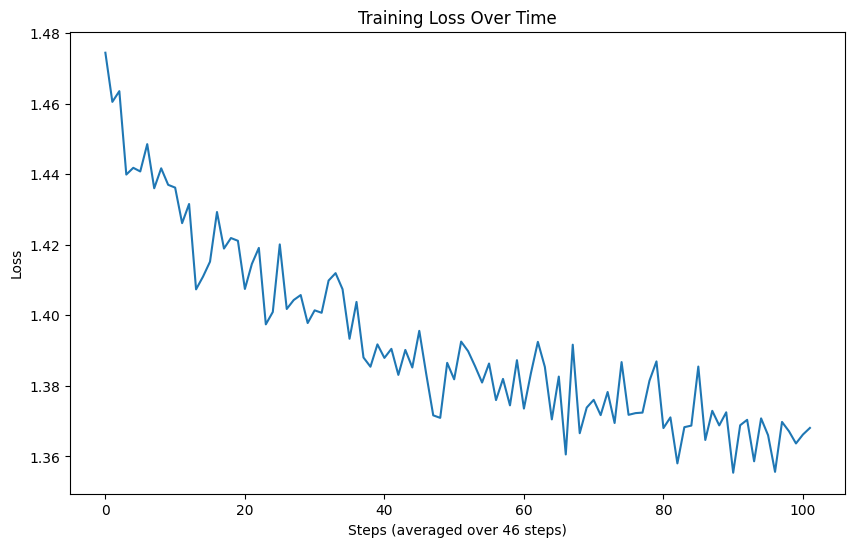

In [59]:
plot_loss(lossi)

In [60]:
# plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [61]:
def get_nearest_neighbors(word, stoi, embeddings, n=5):
    """
    Find the top-n nearest neighbors of a word in the embedding space.
    
    Args:
        word (str): The target word.
        stoi (dict): Mapping from words to indices.
        embeddings (torch.Tensor): Learned word embeddings (shape: V x d).
        n (int): Number of nearest neighbors to retrieve.
    
    Returns:
        List of tuples (neighbor_word, similarity_score).
    """
    if word not in stoi:
        return f"'{word}' not in vocabulary."
    
    word_idx = stoi[word]
    word_embedding = embeddings[word_idx].unsqueeze(0)  # Shape: 1 x d
    
    # Compute cosine similarity between the target embedding and all embeddings
    similarities = cosine_similarity(word_embedding.detach().numpy(), embeddings.detach().numpy())
    similarities = similarities[0]  # Flatten
    
    # Get top-n similar words (excluding the word itself)
    nearest_indices = similarities.argsort()[-n-1:][::-1][1:]  # Exclude the word itself
    nearest_words = [(list(stoi.keys())[idx], similarities[idx]) for idx in nearest_indices]
    return nearest_words



In [62]:
# Example usage
word = "pollen"
nearest_neighbors = get_nearest_neighbors(word, word_to_idx, word2vec.embeddings.weight, n=5)
print(f"Nearest neighbors of '{word}':")
print(nearest_neighbors)


Nearest neighbors of 'pollen':
'pollen' not in vocabulary.


In [63]:
# Using random
# Make a copy so you don't shuffle the original list
words_sample = processed_words.copy()
random.shuffle(words_sample)

# Print first 10 shuffled words
print("Random sample of words:")
print(words_sample[:20])

Random sample of words:
['country', 'ad', 'them', 'that', 'it', 'called', 'a', 'ch', 'first', 'held', 'to', 'following', 'air', 'the', 'capitalism', 'to', 'to', 'the', 'to', 'the']


In [64]:
word2vec.embeddings.weight.shape

torch.Size([3727, 20])

In [65]:
# Lets build the regression model

title = "anarchism originated as a term of abuse first used against early working class radicals"
title_words, title_words_to_idx = preprocess_text(title,1)
# title_idx = word_to_idx['anarchism']
# title_words, 
title_words
# word2vec.embeddings.weight[:10].shape

['anarchism',
 'originated',
 'a',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radical']

In [66]:
def get_word_indices(words: List[str], word_to_idx: dict) -> List[int]:
    """
    Get indices for a list of words, with error handling for unknown words.
    
    Args:
        words: List of words to look up
        word_to_idx: Dictionary mapping words to indices
    
    Returns:
        List of indices for the input words. Unknown words will be noted.
    """
    indices = []
    unknown_words = []
    
    for word in words:
        if word in word_to_idx:
            indices.append(word_to_idx[word])
        else:
            unknown_words.append(word)
    
    # Uncomment below to print unknown words
    # if unknown_words:
    #     print(f"Warning: Words not in vocabulary: {unknown_words}")
    
    return indices

In [67]:
# Get a tensor of indexes for tokenized words in input title
title_idx = torch.tensor(get_word_indices(title_words, word_to_idx))

word2vec.embeddings.weight[title_idx].shape, title_idx.shape

avg_pooling = torch.mean(word2vec.embeddings.weight[title_idx], dim= 0)
# avg_pooling.unsqueeze(dim=0).shape
avg_pooling.shape, word2vec.embeddings.weight[title_idx].shape


(torch.Size([20]), torch.Size([14, 20]))

In [77]:
def get_title_embeddings(title: str, word2vec: nn.Module, word_to_idx: dict) -> torch.Tensor:
    """
    Process a single title and get its embedding representation.
    """
    # Preprocess the title
    title_words, _ = preprocess_text(title, min_freq=1)  # min_freq=1 since we're using existing vocabulary
    
    # Get indices for words that exist in our vocabulary
    title_idx = get_word_indices(title_words, word_to_idx)
    
    # Uncomment below for printing when title not included 
    # if not title_idx:  # If no words from title are in vocabulary
    #     print(f"Warning: No words from title found in vocabulary: {title}")
    #     return None
    
    # Convert to tensor and get embeddings
    title_tensor = torch.tensor(title_idx, dtype=torch.long)
    word_embeddings = word2vec.embeddings.weight[title_tensor].detach() # Detach to avoid tracking gradients from word2vec
    
    # Average the word embeddings to get title embedding
    title_embedding = torch.mean(word_embeddings, dim=0)
    
    return title_embedding

# Process all titles in the dataframe
def prepare_regression_dataset(df: pd.DataFrame, word2vec: nn.Module, word_to_idx: dict) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Prepare dataset for regression model.
    """
    title_embeddings = []
    scores = []
    
    for idx, row in df.iterrows():
        title_emb = get_title_embeddings(row['title'], word2vec, word_to_idx)
        if title_emb is not None and not torch.isnan(title_emb).any():  # Only include if we got valid embeddings
            title_embeddings.append(title_emb)
            scores.append(row['score'])
    
    # Stack all embeddings and scores
    X = torch.stack(title_embeddings)
    Y = torch.tensor(scores, dtype=torch.float).reshape(-1, 1)
    
    return X, Y

# Example usage:
# First, ensure word2vec is trained on combined dataset
# Then prepare regression dataset
X_titles, Y_scores = prepare_regression_dataset(df, word2vec, word_to_idx)

print(f"Dataset shapes - X: {X_titles.shape}, y: {Y_scores.shape}")
print(f"Sample scores: {Y_scores[:5].squeeze()}")
print(X_titles[:10].dtype)
print(X_titles[:10])

Dataset shapes - X: torch.Size([7567, 20]), y: torch.Size([7567, 1])
Sample scores: tensor([ 8., 62.,  1.,  1.,  2.])
torch.float32
tensor([[-0.7956,  0.3645, -0.2649, -0.3656, -0.2964, -0.5467, -0.0615, -0.1068,
          0.2167,  0.5863,  0.4340,  0.6665,  0.0364,  0.0570, -0.1958,  0.6612,
         -0.3121, -0.1556, -0.4343,  0.0285],
        [-0.0154, -0.1454,  1.0242, -0.0073, -0.1848,  0.6347, -0.2985,  0.6058,
         -0.5334, -0.6250, -0.5470, -0.1749, -0.1629,  0.4863,  0.6589, -0.3425,
         -0.0696, -0.2098,  0.1485,  0.1731],
        [-0.6162, -0.0877,  0.6994, -0.3604, -0.5395,  0.5786,  0.2867, -0.2762,
          0.0690, -0.1263, -0.0982, -0.0039, -0.2433,  0.1414,  0.7383,  0.6488,
         -0.4515,  0.6960, -0.0731, -1.0586],
        [-0.5687,  1.1848,  0.0820,  0.2764, -0.2918, -0.6866, -0.6163, -0.2802,
          0.0085, -0.4782, -0.0610,  0.5441, -0.8858,  0.0931, -1.1854, -0.0535,
          0.8694, -0.0911,  0.2068,  0.4297],
        [ 0.2534,  0.8215,  0.6671, 

In [71]:
# Build the regression model

class RegressionModel(nn.Module):
    def __init__(self, emb_dims, hidden_dims):
        super().__init__()
        self.emb_dims = emb_dims
        self.hidden_dims = hidden_dims

        # Define layers
        self.layer1 = nn.Linear(in_features=self.emb_dims, out_features=self.hidden_dims, bias= True)
        self.layer2 = nn.Linear(in_features=self.hidden_dims, out_features=self.hidden_dims, bias= True)
        self.out_layer = nn.Linear(in_features=self.hidden_dims, out_features= 1, bias= True)

        # Define ReLU activation
        self.relu = nn.ReLU()

    def forward(self, x):
        h1 = self.relu(self.layer1(x))
        h2 = self.relu(self.layer2(h1))
        out = self.out_layer(h2)
        return out 

# Set hidden dimensions
hidden_dims = 20

# Instantiate the model
regression_model = RegressionModel(emb_dims= emb_dims, hidden_dims=hidden_dims)

# Define loss function
regression_loss_fn = nn.MSELoss()  

In [78]:
# Check initial tensor types
print("Initial tensor types:")
print(f"X_titles dtype: {X_titles.dtype}")
print(f"Y_scores dtype: {Y_scores.dtype}")
print(f"Model weight dtype: {next(regression_model.parameters()).dtype}")

# Create dataset and check batch types
dataset = torch.utils.data.TensorDataset(X_titles, Y_scores)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Check first batch
for batch_X, batch_y in dataloader:
    print("\nBatch tensor types:")
    print(f"batch_X dtype: {batch_X.dtype}")
    print(f"batch_y dtype: {batch_y.dtype}")
    break

# Try a single forward pass
try:
    print("\nTesting forward pass:")
    predictions = regression_model(batch_X)
    print(f"Predictions dtype: {predictions.dtype}")
except Exception as e:
    print(f"Error in forward pass: {str(e)}")

Initial tensor types:
X_titles dtype: torch.float32
Y_scores dtype: torch.float32
Model weight dtype: torch.float32

Batch tensor types:
batch_X dtype: torch.float32
batch_y dtype: torch.float32

Testing forward pass:
Predictions dtype: torch.float32


In [80]:
# Debug version of training loop
print("Starting debug...")

try:
    # Get first batch
    for batch_X, batch_y in dataloader:
        print("\nBatch information:")
        print(f"batch_X shape: {batch_X.shape}, dtype: {batch_X.dtype}")
        print(f"batch_y shape: {batch_y.shape}, dtype: {batch_y.dtype}")
        
        # Check model parameters
        print("\nModel parameters:")
        for name, param in regression_model.named_parameters():
            print(f"{name} dtype: {param.dtype}")
        
        # Try forward pass step by step
        print("\nForward pass steps:")
        print("1. First layer")
        h1 = regression_model.layer1(batch_X)
        print("   Passed layer1")
        
        print("2. First ReLU")
        h1 = regression_model.relu(h1)
        print("   Passed ReLU")
        
        print("3. Second layer")
        h2 = regression_model.layer2(h1)
        print("   Passed layer2")
        
        print("4. Second ReLU")
        h2 = regression_model.relu(h2)
        print("   Passed ReLU")
        
        print("5. Output layer")
        out = regression_model.out_layer(h2)
        print("   Passed output layer")
        
        print("\nAll steps completed successfully")
        break
        
except Exception as e:
    print(f"\nError occurred at: {str(e)}")
    # Print local variables if available
    if 'batch_X' in locals():
        print(f"Last batch_X dtype: {batch_X.dtype}")
    if 'h1' in locals():
        print(f"Last h1 dtype: {h1.dtype}")

Starting debug...

Batch information:
batch_X shape: torch.Size([32, 20]), dtype: torch.float32
batch_y shape: torch.Size([32, 1]), dtype: torch.float32

Model parameters:
layer1.weight dtype: torch.float32
layer1.bias dtype: torch.float32
layer2.weight dtype: torch.float32
layer2.bias dtype: torch.float32
out_layer.weight dtype: torch.float32
out_layer.bias dtype: torch.float32

Forward pass steps:
1. First layer
   Passed layer1
2. First ReLU
   Passed ReLU
3. Second layer
   Passed layer2
4. Second ReLU
   Passed ReLU
5. Output layer
   Passed output layer

All steps completed successfully


In [ ]:
# Update 2

# Training loop
reg_epochs = 1000
batch_size = 32

# Create DataLoader
dataset = torch.utils.data.TensorDataset(X_titles, Y_scores)
dataloader = torch.utils.data.DataLoader(dataset, 
                                       batch_size=batch_size, 
                                       shuffle=True)

# Initialize optimizer
regression_optimizer = torch.optim.Adam(regression_model.parameters())
losses = []

print("Starting training...")
print(f"Dataset size: {len(X_titles)}")
print(f"Number of batches: {len(dataloader)}")

print(f"X_titles shape: {X_titles.shape}")
print(f"Y_scores shape: {Y_scores.shape}")
print(f"Sample batch shapes: {next(iter(dataloader))[0].shape}, {next(iter(dataloader))[1].shape}")

for epoch in range(reg_epochs):
    epoch_loss = 0
    for batch_idx, (batch_X, batch_y) in enumerate(dataloader):
        
        # Zero gradients
        regression_optimizer.zero_grad()
        
        # Forward pass
        predictions = regression_model(batch_X)
        
        # Compute loss
        loss = regression_loss_fn(predictions, batch_y)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        regression_optimizer.step()
        
        # Track loss
        epoch_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}/{reg_epochs} | Batch {batch_idx}/{len(dataloader)} | "
                  f"Loss: {loss.item():.4f}")
    
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{reg_epochs} complete | Avg Loss: {avg_loss:.4f}")

Starting training...
Dataset size: 7567
Number of batches: 237
X_titles shape: torch.Size([7567, 20])
Y_scores shape: torch.Size([7567, 1])
Sample batch shapes: torch.Size([32, 20]), torch.Size([32, 1])
Epoch 1/1000 | Batch 0/237 | Loss: 10945.6709
Epoch 1/1000 | Batch 100/237 | Loss: 17875.7773
Epoch 1/1000 | Batch 200/237 | Loss: 1337.7999
Epoch 1/1000 complete | Avg Loss: 5353.7083
Epoch 2/1000 | Batch 0/237 | Loss: 2187.4475
Epoch 2/1000 | Batch 100/237 | Loss: 9139.4355
Epoch 2/1000 | Batch 200/237 | Loss: 3885.3809
Epoch 2/1000 complete | Avg Loss: 5349.0714
Epoch 3/1000 | Batch 0/237 | Loss: 2109.4412
Epoch 3/1000 | Batch 100/237 | Loss: 7842.4448
Epoch 3/1000 | Batch 200/237 | Loss: 397.0869
Epoch 3/1000 complete | Avg Loss: 5340.2157
Epoch 4/1000 | Batch 0/237 | Loss: 2244.3198
Epoch 4/1000 | Batch 100/237 | Loss: 857.9862
Epoch 4/1000 | Batch 200/237 | Loss: 776.4371
Epoch 4/1000 complete | Avg Loss: 5355.9355
Epoch 5/1000 | Batch 0/237 | Loss: 1711.2963
Epoch 5/1000 | Batch 

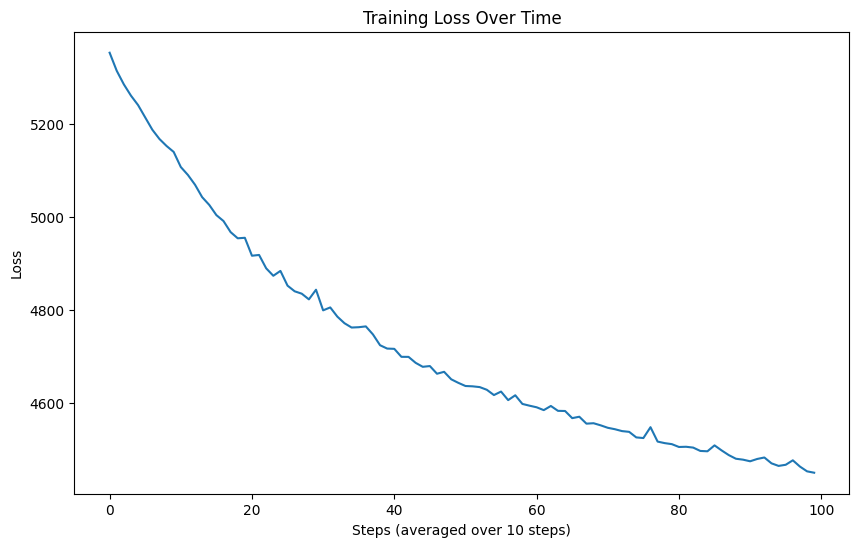

In [84]:
plot_loss(losses)